In [1]:
# k crossover d，close > ema 8, ema 8 > ema 18, ema 18 > 38, take profit atr, stop loss atr
# Variables :
# time - 15m, 1h
# start time - 1609492611000, 1641028611000, 1672564611000 (2021, 2022, 2023)
# tp atr - 4, 6
# sl atr - 3, 5
# sl - Close, Low

In [2]:
# ! conda install -c conda-forge ta --yes

In [3]:
import requests
import pandas as pd
import ta
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np
import time

In [4]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '15m'

# start epoch till now
start_time = 1641028611000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [5]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [6]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

                Close_Time     Open    Close     High      Low     Volume
0      2022-01-01 17:44:59  3722.52  3713.95  3726.91  3709.38  1052.7796
1      2022-01-01 17:59:59  3713.95  3718.67  3720.15  3710.87   811.7021
2      2022-01-01 18:14:59  3718.67  3719.64  3731.88  3717.97  1415.8797
3      2022-01-01 18:29:59  3719.64  3691.22  3719.90  3688.18  3344.1421
4      2022-01-01 18:44:59  3691.22  3698.61  3699.97  3673.46  3851.5917
...                    ...      ...      ...      ...      ...        ...
43564  2023-03-31 13:59:59  1802.30  1796.62  1802.61  1792.63  5841.1991
43565  2023-03-31 14:14:59  1796.61  1796.80  1798.03  1795.05  3476.4248
43566  2023-03-31 14:29:59  1796.80  1797.82  1798.54  1796.20  2140.3035
43567  2023-03-31 14:44:59  1797.81  1799.17  1800.00  1796.16  1771.7849
43568  2023-03-31 14:59:59  1799.18  1798.39  1799.88  1796.98  2410.2598

[43569 rows x 6 columns]


In [7]:
df = rawdf.copy()

In [8]:
def indicators(df):

# ema
    for i in (8, 18, 38):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr8
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)
    
# rsi
    rsi_int = 14
    df['rsi'] = ta.momentum.RSIIndicator(df['Close'], window = rsi_int).rsi()

# kd
    kd_int = 14
    d_int = 3
   
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slowk'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slowd'] = df['slowk'].rolling(d_int).mean()
    
    return df

def checkcross(df):
    series = df['slowk'] > df['slowd']
    return series.diff()

In [9]:
indicators(df)
df['kd_cross'] = checkcross(df)
print(df)

                Close_Time     Open    Close     High      Low     Volume  \
0      2022-01-01 17:44:59  3722.52  3713.95  3726.91  3709.38  1052.7796   
1      2022-01-01 17:59:59  3713.95  3718.67  3720.15  3710.87   811.7021   
2      2022-01-01 18:14:59  3718.67  3719.64  3731.88  3717.97  1415.8797   
3      2022-01-01 18:29:59  3719.64  3691.22  3719.90  3688.18  3344.1421   
4      2022-01-01 18:44:59  3691.22  3698.61  3699.97  3673.46  3851.5917   
...                    ...      ...      ...      ...      ...        ...   
43564  2023-03-31 13:59:59  1802.30  1796.62  1802.61  1792.63  5841.1991   
43565  2023-03-31 14:14:59  1796.61  1796.80  1798.03  1795.05  3476.4248   
43566  2023-03-31 14:29:59  1796.80  1797.82  1798.54  1796.20  2140.3035   
43567  2023-03-31 14:44:59  1797.81  1799.17  1800.00  1796.16  1771.7849   
43568  2023-03-31 14:59:59  1799.18  1798.39  1799.88  1796.98  2410.2598   

             ema_8       ema_18       ema_38       atr        rsi      slow

In [10]:
def conditions(df):
    # k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['Close'] >= df['ema_8']
        # c3
        df['c3'] = df['ema_8'] >= df['ema_18']
        # c4
        df['c4'] = df['ema_18'] >= df['ema_38']

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4 , 'signal'] = True


    # 下一根進場
    df['openbuy'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'openbuy'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [11]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_18,ema_38,atr,rsi,slowk,slowd,kd_cross,c1,c2,c3,c4,signal,openbuy
0,2022-01-01 17:44:59,3722.52,3713.95,3726.91,3709.38,1052.7796,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False
1,2022-01-01 17:59:59,3713.95,3718.67,3720.15,3710.87,811.7021,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
2,2022-01-01 18:14:59,3718.67,3719.64,3731.88,3717.97,1415.8797,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
3,2022-01-01 18:29:59,3719.64,3691.22,3719.90,3688.18,3344.1421,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
4,2022-01-01 18:44:59,3691.22,3698.61,3699.97,3673.46,3851.5917,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43564,2023-03-31 13:59:59,1802.30,1796.62,1802.61,1792.63,5841.1991,1801.614425,1801.673084,1799.049840,4.720656,43.793816,24.798011,31.202767,False,False,False,False,True,False,False
43565,2023-03-31 14:14:59,1796.61,1796.80,1798.03,1795.05,3476.4248,1800.544552,1801.160128,1798.934464,4.596323,44.117669,25.916718,27.337207,False,False,False,False,True,False,False
43566,2023-03-31 14:29:59,1796.80,1797.82,1798.54,1796.20,2140.3035,1799.939096,1800.808535,1798.877312,4.435157,46.015867,32.256060,27.656930,True,True,False,False,True,False,False
43567,2023-03-31 14:44:59,1797.81,1799.17,1800.00,1796.16,1771.7849,1799.768186,1800.636058,1798.892321,4.392646,48.508842,40.646364,32.939714,False,False,False,False,True,False,False


In [12]:
entry_df = conditions(df)

in_position = False
stop_loss = np.nan
take_profit = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']

sl_atr = 3
tp_atr = 6

for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'openbuy'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = close_val.shift(1).at[index] - sl_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] + tp_atr * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Buy'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
        take_profit = entry_df.at[index, 'take_profit']
    

    # 吃筍
    #-----------------------------重要-----------------------------
    # 若用 if 寫，則有可能入場馬上吃筍，若用 elif 則一個 iteration 只會執行一次
    elif in_position == True and (entry_df.at[index, 'Close'] <= stop_loss):
        entry_df.at[index, 'position'] = 'Stop'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan

    # set take profit
    elif in_position == True and (entry_df.at[index, 'High'] >= take_profit):
        entry_df.at[index, 'position'] = 'Sell'
        in_position = False
        stop_loss = np.nan
        take_profit = np.nan
        
entry_df.to_csv('entry_df.csv')
        
raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['openbuy'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Buy') |
              (entry_df['position'] == 'Sell') |
              (entry_df['position'] == 'Stop')]

print(entry_df)

                Close_Time     Open    Close     High      Low     Volume  \
37     2022-01-02 02:59:59  3744.61  3752.58  3756.99  3741.55  1566.7805   
38     2022-01-02 03:14:59  3752.58  3749.35  3757.86  3746.18  1237.6915   
39     2022-01-02 03:29:59  3749.36  3744.38  3749.84  3736.31  1301.9566   
41     2022-01-02 03:59:59  3738.87  3747.61  3749.36  3736.59   810.7879   
42     2022-01-02 04:14:59  3747.60  3746.55  3749.83  3742.45  1009.3066   
...                    ...      ...      ...      ...      ...        ...   
43547  2023-03-31 09:44:59  1810.41  1803.98  1811.50  1801.01  5871.5254   
43550  2023-03-31 10:29:59  1800.02  1804.14  1804.27  1799.39  2806.8865   
43551  2023-03-31 10:44:59  1804.13  1802.54  1804.51  1801.99  2396.9798   
43553  2023-03-31 11:14:59  1803.18  1803.87  1804.62  1802.46  2944.8985   
43554  2023-03-31 11:29:59  1803.86  1806.42  1806.62  1803.43  3165.9741   

             ema_8       ema_18       ema_38        atr  ...     c1     c2 

In [13]:
# 部位回測

pos_df = entry_df.copy()
pos_df = pos_df.reset_index(drop = True)
pos_df = pos_df[(pos_df['position'] == 'Buy') |
              (pos_df['position'] == 'Sell') |
              (pos_df['position'] == 'Stop')]

# 一次進場多少單位
pos_size = 1

col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'ema_8', 'ema_18', 'ema_38', 'atr', 'kd_cross', 'position','entry_p', 'stop_loss', 'take_profit']
pos = pos_df[col]
pos = pos.reset_index(drop = True)


for index, row in pos.iterrows():
    
    current_pos = 0
    
    # 進場
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'size'] = pos_size
        pos.exit_p = np.nan
    
    # 出場
    if pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        
        #-----------------------------重要-----------------------------
        # 實戰需即刻出場
        
        # 停利：達成條件時收盤價
        if pos.at[index, 'position'] == 'Sell':
#             pos.at[index, 'exit_p'] = pos.at[index, 'Close']
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'take_profit']
                break

        # 停損：打到進場停損點（往回跌代，直到最近的'Buy'及其'stop_loss'）
        if pos.at[index, 'position'] == 'Stop':
            for i in range(index -1, -1, -1):
                if pos.at[i, 'position'] == 'Buy':
                    pos.at[index, 'exit_p'] = pos.at[i, 'stop_loss']
                break

        # 計算每次出場部位大小（每次出場皆清倉）
        for i in range(index -1, -1, -1):
            if pos.at[i, 'position'] == 'Buy':
                current_pos += pos.at[i, 'size']
                if i == 0:
                    pos.at[index, 'size'] = -current_pos
                else:
                    continue
            else:
                pos.at[index, 'size'] = -current_pos
                current_pos = 0
                break


# 計算部位價值
for index, row in pos.iterrows():
    if pos.at[index, 'position'] == 'Buy':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'entry_p'], 4)
    elif pos.at[index, 'position'] == 'Sell' or pos.at[index, 'position'] == 'Stop':
        pos.at[index, 'amt'] = round(pos.at[index, 'size'] * pos.at[index, 'exit_p'], 4)


# 若最後一筆為 Buy，移除該單，迭代驗證
for index, row in pos.iloc[::-1].iterrows():
    if row['position'] == 'Buy':
        pos = pos.drop(index)
    else:
        break
        


# 手續費、滑點、價差
fee = 0.05 / 100
amt_abs_sum = pos.amt.abs().sum()
ttl_fee = amt_abs_sum * fee

# 損益
leverage = 10
ttl_profit = -pos.amt.sum() - ttl_fee


# 計算進場最大部位，最大損益
consec_entry = 0
position_amt_sum = 0
max_consec_entry = 0
max_position = 0
max_profit = 0
max_loss = 0

for index, row in pos.iterrows():
    
    if row['position'] == 'Buy':
        
        consec_entry += 1
        position_amt_sum += row['amt']
        
    elif row['position'] in ['Sell', 'Stop']:
        
        if consec_entry > max_consec_entry:
            max_consec_entry = consec_entry
            max_position = position_amt_sum
            
        position_amt_sum += row['amt']
        
        if -position_amt_sum > max_profit:
            max_profit = -position_amt_sum
            
        if -position_amt_sum < max_loss:
            max_loss = -position_amt_sum
            
        consec_entry = 0
        position_amt_sum = 0
    
    else:
        pass


profit_per = "{:.2f}%".format(ttl_profit / (max_position/leverage) * 100)

wins = pos['position'].str.count('Sell').sum()
loses = pos['position'].str.count('Stop').sum()

win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Max_Profit': [round(max_profit, 2)],
          'Max_Loss': [round(max_loss, 2)],
          'Max_Entry': [max_consec_entry],
          'Max_Position': [round(max_position, 2)],
          'Profit_%': [profit_per],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)
print()
print(pos)

pos.to_csv('pos.csv')


    Profit       Fee  Max_Profit  Max_Loss  Max_Entry  Max_Position Profit_%  \
0  7566.57  10277.91     5558.59   -835.08         53      83920.37   90.16%   

  Win_Rate  
0   11.16%  

               Close_Time     Open    Close     High      Low        ema_8  \
0     2022-01-02 03:14:59  3752.58  3749.35  3757.86  3746.18  3747.529565   
1     2022-01-02 03:29:59  3749.36  3744.38  3749.84  3736.31  3746.829662   
2     2022-01-02 04:14:59  3747.60  3746.55  3749.83  3742.45  3745.831021   
3     2022-01-02 05:14:59  3761.02  3773.19  3774.88  3760.28  3757.171843   
4     2022-01-02 05:29:59  3773.18  3762.48  3776.00  3760.21  3758.351433   
...                   ...      ...      ...      ...      ...          ...   
5747  2023-03-30 16:44:59  1806.27  1799.09  1806.37  1798.37  1802.049739   
5748  2023-03-30 19:14:59  1803.52  1801.87  1804.12  1801.86  1801.496380   
5749  2023-03-30 20:59:59  1804.84  1804.21  1805.88  1802.73  1802.957942   
5750  2023-03-30 21:29:59  1803.

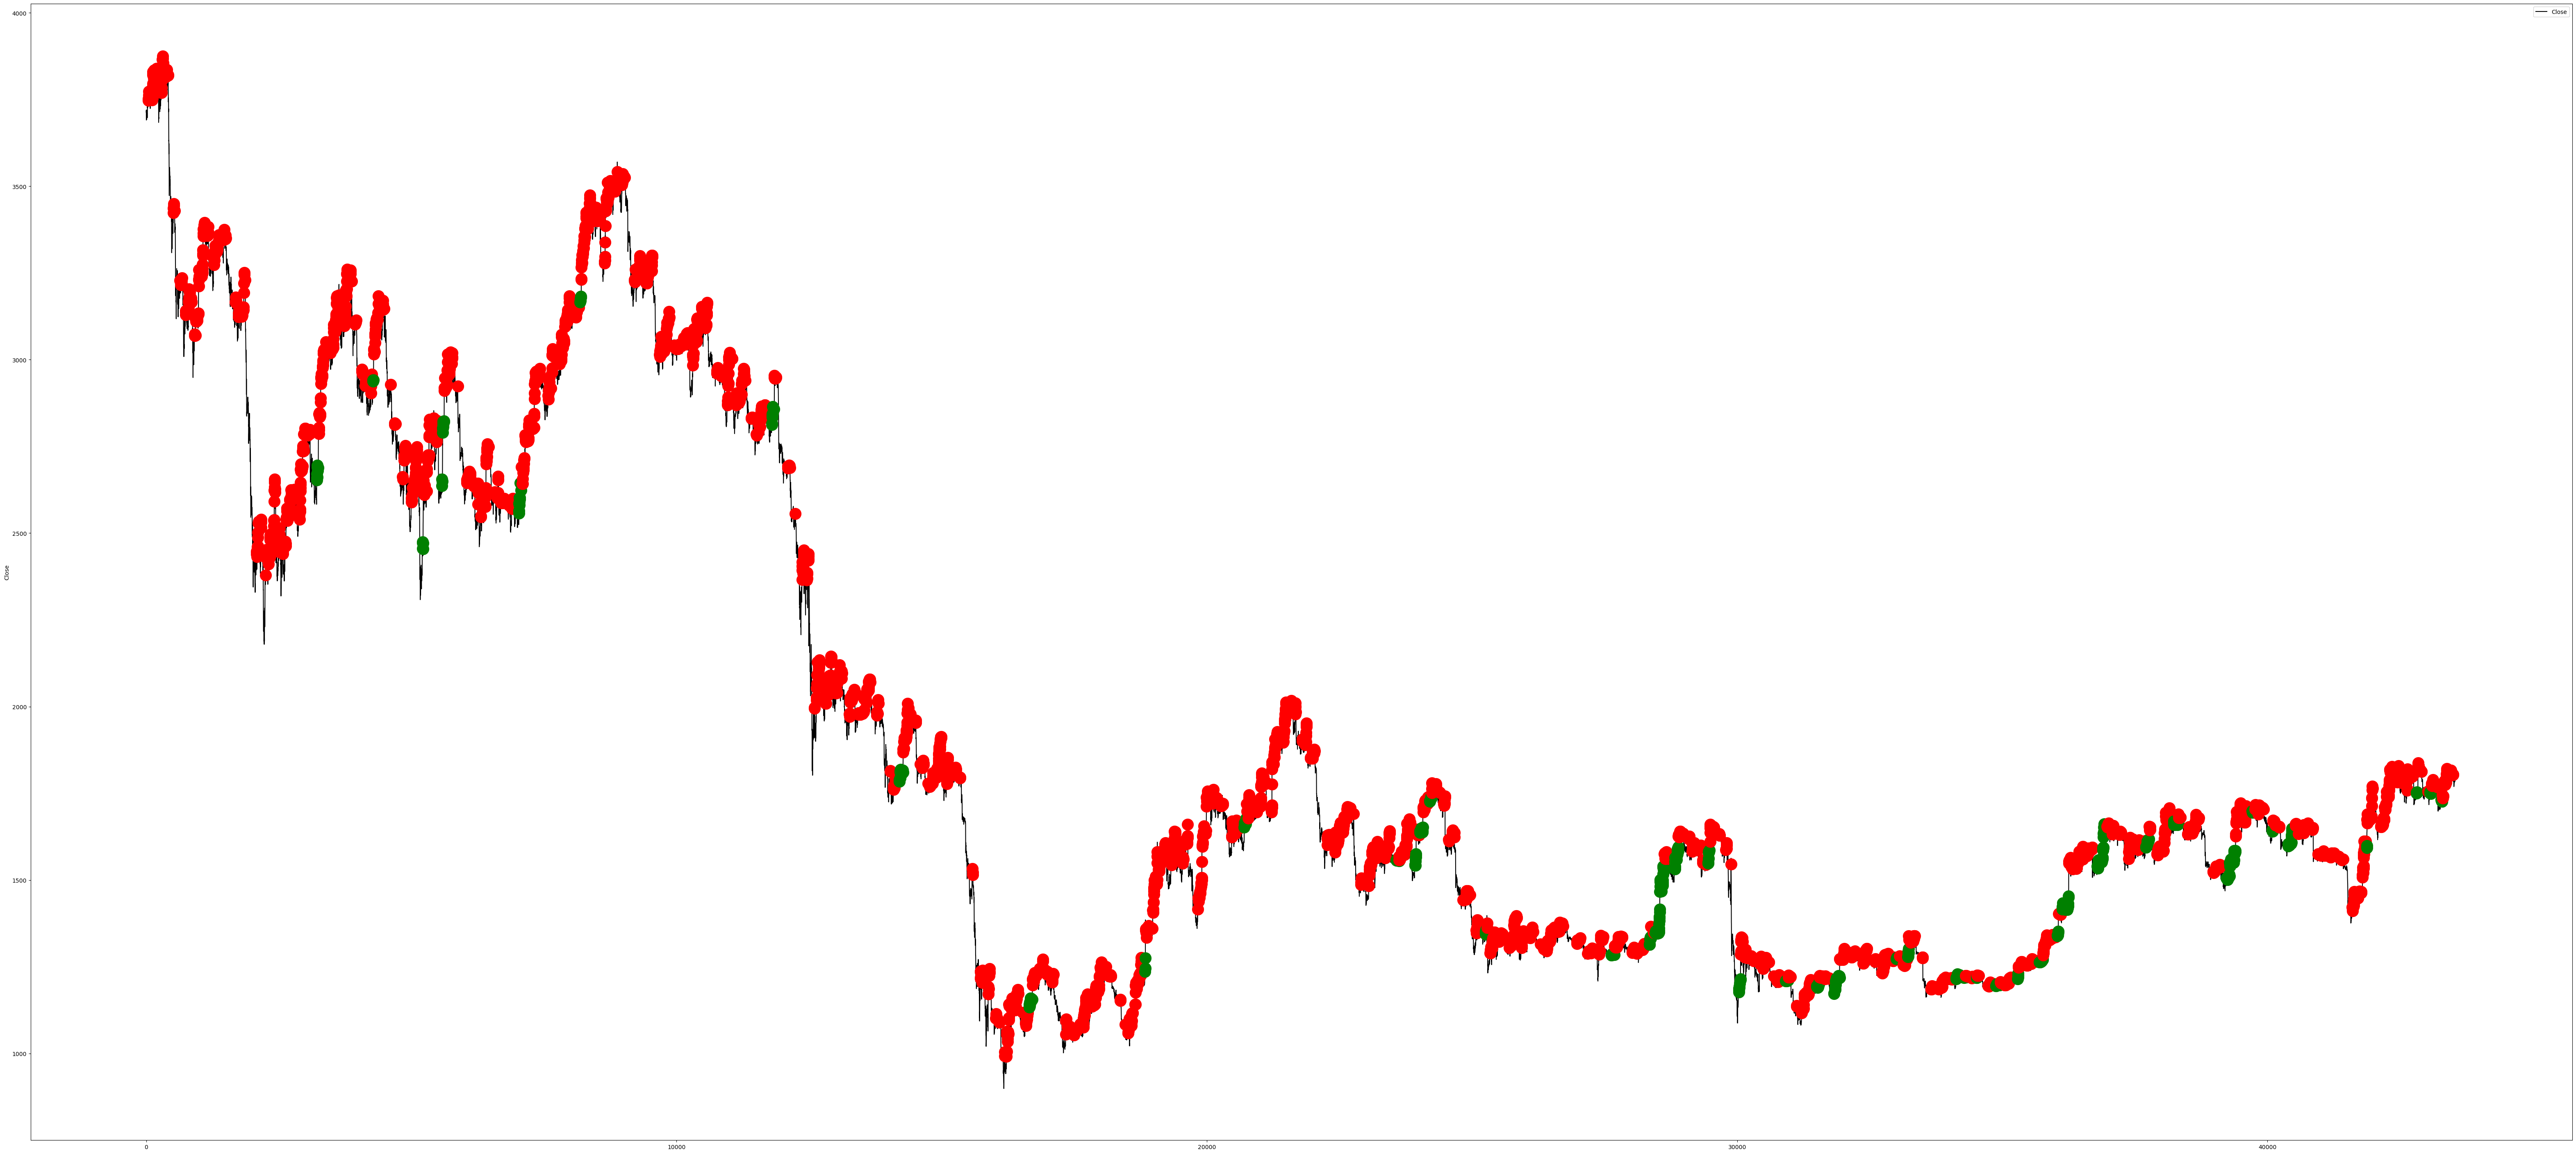

In [14]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')

i = 0
while i < len(plt_df):
    if pd.isna(plt_df.position[i]):
        i += 1
    elif plt_df.position[i] == 'Buy':
        j = i + 1
        while j < len(plt_df) and (pd.isna(plt_df.position[j]) or plt_df.position[j] == 'Buy'):
            j += 1
        if j < len(plt_df) and plt_df.position[j] == 'Sell':
            # Paint all previous 'Buy's green dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'go', label='_', markersize=20)
            i = j
        elif j < len(plt_df) and plt_df.position[j] == 'Stop':
            # Paint all previous 'Buy's red dot
            for k in range(i, j+1):
                plt.plot(k, plt_df.entry_p[k], 'ro', label='_', markersize=20)
            i = j + 1
        else:
            i = j
    else:
        i += 1

plt.legend()
plt.show()


# 之所以出現大量紅點，原因為：連續加倉會調整整個部位停利和停損，因此一些進倉部位會因為調高後的＂整個部位＂停損而出場，但該入場損益依舊為正
# 意思是該部位之停損已經高於許多前面部位之進場點位